In [ ]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch

from juart.conopt.functional.fourier import (
    fourier_transform_forward,
    nonuniform_fourier_transform_adjoint,
    nonuniform_fourier_transform_forward,
)
from juart.ellipsoid_phantoms.ellipsoids import SheppLogan
from juart.recon.ncgrappa import NonCartGrappa
from juart.recon.sense import cgsense
from juart.utils import resize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
def archimedean_spiral(num_points, FOV, matrix_size, N=1):
    """
    Generate (x, y) coordinates for an Archimedean spiral in k-space.

    Parameters:
    - num_points: Number of points in the spiral.
    - FOV: Field of view in meters.
    - matrix_size: Size of the matrix (e.g., 200 for a 200x200 matrix).
    - N: Number of spirals to generate.

    Returns:
    - k: A 2D array of shape (2, num_points, N) containing the spiral coordinates.
    """
    # Compute theta_max from your stopping point equation
    k_max = matrix_size / FOV / 2

    dtheta = 2 * torch.pi / N
    theta_max = (2 * torch.pi / N) * k_max * FOV
    theta = torch.linspace(0, theta_max, num_points)

    # Spiral radius as a function of theta
    r = (N * theta) / (2 * torch.pi * FOV)

    k = torch.zeros((2, num_points, N), dtype=torch.float32)

    for n in range(N):
        # Spiral in the complex plane
        x = r * torch.cos(theta + (dtheta * n))
        y = r * torch.sin(theta + (dtheta * n))

        k[0, :, n] = x
        k[1, :, n] = y
    return k

In [119]:
acs_size = 30
field_of_view = 0.2  # in meters
matrix_size = 200
num_lve = 4

# Create Shepp Logan Phantom


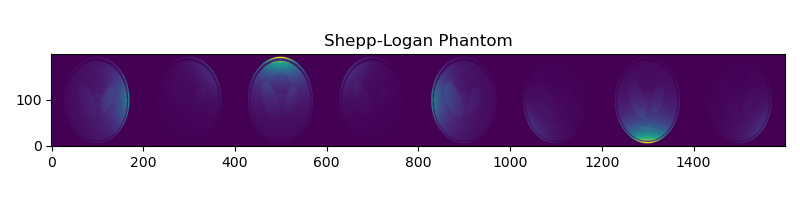

In [120]:
# Create a Shepp-Logan phantom
sl_phantom = SheppLogan(
    fov=[field_of_view, field_of_view],
    matrix=[matrix_size, matrix_size],
)
# Add coil for sensitivity maps
sl_phantom.add_coil()

# Get image space object
img = sl_phantom.get_object()

# Remove echo dimension
img = img[..., 0]

# Add dummy coil sens
# img = img[None, ..., None].tile(8, 1, 1, 1)
# coil_sens = torch.ones_like(img)

# Show the Shepp-Logan phantom with coil sensitivity
plt.figure(figsize=(8, 2))
plt.title("Shepp-Logan Phantom")
plt.imshow(img.reshape(-1, img.shape[1]).abs().numpy().T, origin="lower")
plt.tight_layout()

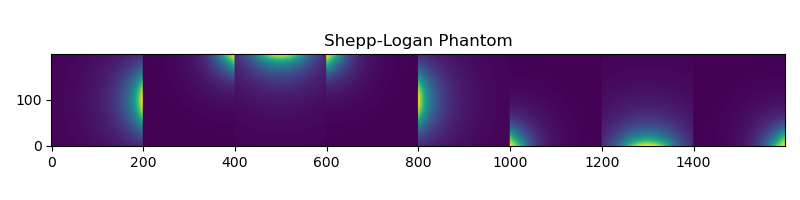

In [121]:
coil_sens = sl_phantom.coil.get_sens_maps(
    matrix=[matrix_size, matrix_size], fov=[field_of_view, field_of_view]
)

coil_sens = torch.from_numpy(coil_sens)


plt.figure(figsize=(8, 2))
plt.title("Shepp-Logan Phantom")
plt.imshow(coil_sens.reshape(-1, coil_sens.shape[1]).abs().numpy().T, origin="lower")
plt.tight_layout()

# Create spiral trajectory data and ACS region

In [122]:
import scipy.io

spiral_data = scipy.io.loadmat("spiral_data.mat")
ktraj_comb = spiral_data["usTraj"]
ktraj_comb = torch.from_numpy(ktraj_comb)
ktraj_comb = torch.moveaxis(ktraj_comb, -1, 0)  # Move spatial dims to start
ktraj_comb = ktraj_comb[[1, 2, 0], ...]  # Reorder to (mask, x, y) -> (x, y, mask)

sample_mask = ktraj_comb[-1] == 1
ktraj = ktraj_comb[:2, sample_mask]

In [ ]:
# ktraj = archimedean_spiral(
# num_points=12000, FOV=field_of_view, matrix_size=matrix_size, N=num_lve)

print(ktraj.max())
# ktraj = torch.rand(2, 20000, 4) - 0.5

## Scale trajectory from -0.5 to 0.5
# ktraj = ktraj * field_of_view / matrix_size
# print(ktraj.max(), ktraj.min())

ksp_spiral = nonuniform_fourier_transform_forward(
    # k = ktraj.reshape(ktraj.shape[0], -1),
    k=ktraj_comb[:2, ...] / matrix_size,
    x=img,
)
# ksp_spiral = ksp_spiral.reshape(img.shape[0], -1, ktraj.shape[-1])

ksp_acs = fourier_transform_forward(
    x=img,
    axes=(-3, -2),
)

ksp_acs = resize(ksp_acs, size=(acs_size, acs_size), dims=(1, 2))

ksp_acs = ksp_acs.flip(
    1, 2
)  # moveax does not work, flip 2 also does not work. flip 1,2 is better but still bad

tensor(99.6116, dtype=torch.float64)


In [124]:
num_dim = ktraj.shape[0]
num_cha = coil_sens.shape[0]

# # Add a undersampling factor of 2 by setting every second interleave to zero
# ktraj_comb = torch.cat(
#     [ktraj, torch.ones((1, *ktraj.shape[1:]), dtype=torch.float32)],
#     dim=0
# )

# ktraj_comb[-1, :, ::2] = 0

ksp_spiral_us = ksp_spiral.clone()
# ksp_spiral_us[..., ::2] = 0
ksp_spiral_us[:, ~sample_mask] = 0

# # Ravel interleaves
# ktraj_comb = ktraj_comb.reshape(ktraj_comb.shape[0], -1)
# ktraj = ktraj.reshape(ktraj.shape[0], -1)
# ksp_spiral_us = ksp_spiral_us.reshape(num_cha, -1)
# ksp_spiral = ksp_spiral.reshape(num_cha, -1)

# sample_mask = ktraj_comb[-1, :] != 0

# # Cut of first few points to avoid overlap
# ktraj_comb = ktraj_comb[:, 5:]
# ksp_spiral_us = ksp_spiral_us[:, 5:]
# ksp_spiral = ksp_spiral[:, 5:]
# sample_mask = sample_mask[5:]

In [125]:
# Save to file for matlab comparison

import scipy.io

scipy.io.savemat(
    "matlab_export.mat",
    {
        "ktraj_comb": ktraj_comb.cpu().numpy(),
        "ksp_spiral_us": ksp_spiral_us.cpu().numpy(),
        "ksp_spiral": ksp_spiral.cpu().numpy(),
        "ksp_acs": ksp_acs.cpu().numpy(),
        "ground_truth": img.cpu().numpy(),
    },
)

# Reconstruct images

## Iterative NUFFT of unsampled data

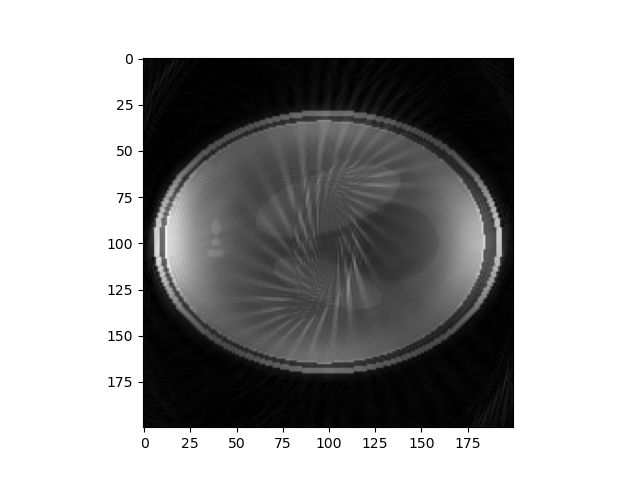

In [126]:
from juart.conopt.linops.tf import TransferFunctionOperator
from juart.conopt.proxops.linear import conjugate_gradient
from juart.conopt.tfs.fourier import nonuniform_transfer_function

regridded_data = nonuniform_fourier_transform_adjoint(
    k=ktraj_comb[:2, sample_mask] / matrix_size,
    x=ksp_spiral_us[:, sample_mask],
    n_modes=(matrix_size, matrix_size),
)

transfer_function = nonuniform_transfer_function(
    k=ktraj_comb[:2, sample_mask] / matrix_size,
    data_shape=(1, *regridded_data.shape[1:]),
)

transfer_function_operator = TransferFunctionOperator(
    transfer_function,
    (num_cha, *regridded_data.shape[1:]),
    axes=(1, 2),
)

# Calculate CG-NUFFT solution with regularization

d_vec = regridded_data.view(torch.float32).ravel()
init_guess = torch.zeros(d_vec.shape, dtype=torch.float32)
ATA = transfer_function_operator

img, _ = conjugate_gradient(A=ATA, b=d_vec, x=init_guess, maxiter=20, residual=[])

img = img.view(torch.complex64).reshape(regridded_data.shape)
img_rss = torch.sqrt(torch.sum(img.abs() ** 2, dim=0, keepdim=True))

plt.figure()
plt.imshow(img_rss[0, ..., 0].abs().numpy(), cmap="gray")

## Non-cart. GRAPPA and iterative NUFFT

In [127]:
# Scale trajectory from -0.5 to 0.5
ncgrappa_operator = NonCartGrappa(
    ktraj=(ktraj_comb / torch.tensor([[matrix_size], [matrix_size], [1]])),
    calib_signal=ksp_acs.squeeze(),
    kernel_size=7,
    img_size=(matrix_size, matrix_size),
    verbose=5,
    shift_tol=1e-6,
    do_sift=True,
    tik=0.03,
)

Scaled kspace trajectory to [cycle/fov] units.
Maximum k-space coordinates [x, y]: tensor([99.6116, 99.6116], dtype=torch.float64)
Minimum k-space coordinates [x, y]: tensor([-99.6116, -99.6116], dtype=torch.float64)

Number of total locations in k-space: 43200
Number of sampled locations in k-space: 21600
Number of unsampled locations in k-space: 21600 

------------------------------------------------
Perform KDTree search of patch constellations.
Neighbor search distance: ±[3.5, 3.5]
Sampled points shape: torch.Size([2, 21600])
Unsampled points shape: torch.Size([2, 21600])
Found 21600 patches.
KDTree search completed in 112.786 ms. 

Number of patches: 21600
[#Neigbors, Num Patches] [[0, 0], [10, 8], [11, 74], [12, 68], [13, 46], [14, 70], [15, 40], [16, 30], [17, 46], [18, 116], [19, 218], [20, 170], [21, 368], [22, 1242], [23, 2018], [24, 2500], [25, 2292], [26, 1680], [27, 1732], [28, 3798], [29, 1020], [30, 712], [31, 452], [32, 192], [33, 192], [34, 208], [35, 158], [36, 140],

Calibrating patch groups: 100%|██████████| 21600/21600 [09:00<00:00, 39.96it/s]   


In [128]:
ksp_filled = ncgrappa_operator.apply(ksp_spiral_us.clone())

Applying GRAPPA weights: 100%|██████████| 21600/21600 [01:21<00:00, 266.57it/s]


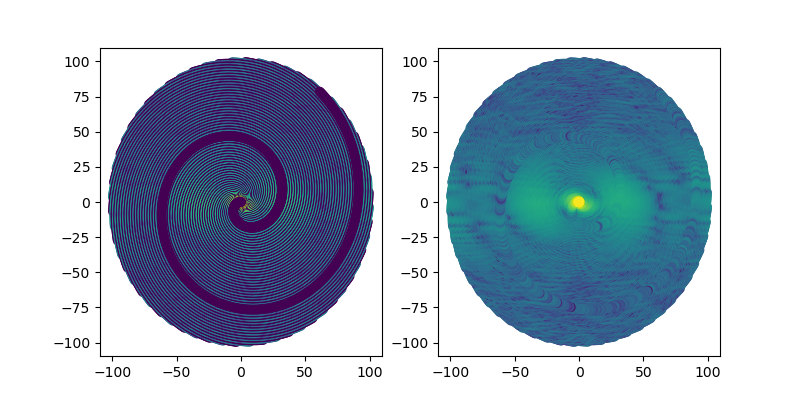

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(
    ktraj_comb[0, :],
    ktraj_comb[1, :],
    c=ksp_spiral_us[0, :].abs().numpy() + 1,
    norm="log",
)
axes[1].scatter(
    ktraj_comb[0, :], ktraj_comb[1, :], c=ksp_filled[0, :].abs().numpy() + 1, norm="log"
)

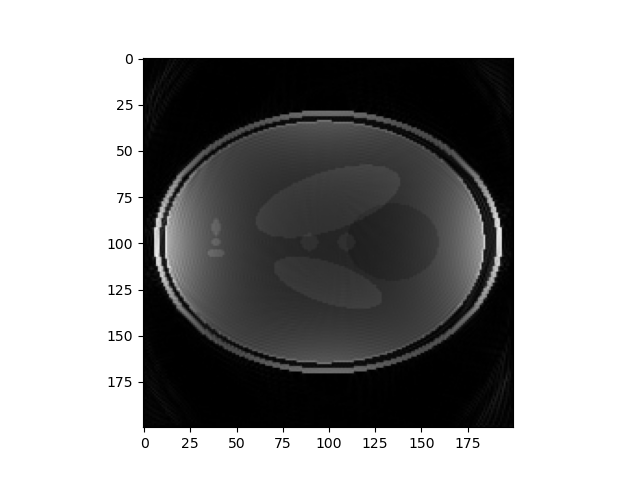

In [137]:
from juart.conopt.linops.tf import TransferFunctionOperator
from juart.conopt.proxops.linear import conjugate_gradient
from juart.conopt.tfs.fourier import nonuniform_transfer_function

regridded_data = nonuniform_fourier_transform_adjoint(
    k=ktraj_comb[:2] / matrix_size,
    x=ksp_filled,
    n_modes=(matrix_size, matrix_size),
)

transfer_function = nonuniform_transfer_function(
    k=ktraj_comb[:2] / matrix_size,
    data_shape=(1, *regridded_data.shape[1:]),
)

transfer_function_operator = TransferFunctionOperator(
    transfer_function,
    (num_cha, *regridded_data.shape[1:]),
    axes=(1, 2),
)

# Calculate CG-NUFFT solution with regularization

d_vec = regridded_data.view(torch.float32).ravel()
init_guess = torch.zeros(d_vec.shape, dtype=torch.float32)
ATA = transfer_function_operator

img, _ = conjugate_gradient(A=ATA, b=d_vec, x=init_guess, maxiter=100, residual=[])

img = img.view(torch.complex64).reshape(regridded_data.shape)
img_rss = torch.sqrt(torch.sum(img.abs() ** 2, dim=0, keepdim=True))

plt.figure()
plt.imshow(img_rss[0, ..., 0].abs().numpy(), cmap="gray")

## Compare with CG-SENSE

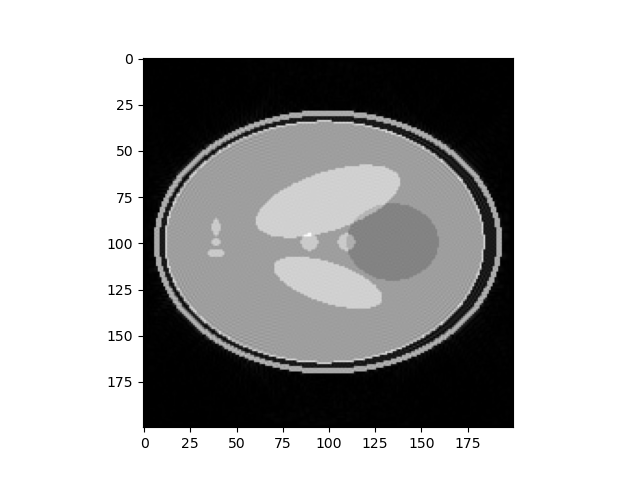

In [138]:
img = cgsense(
    ksp_data=ksp_spiral_us[:, sample_mask],
    ktraj=ktraj_comb[:2, sample_mask] / matrix_size,
    coil_sensitivities=coil_sens,
    maxiter=60,
)

plt.figure()
plt.imshow(img[0, ..., 0].abs().numpy(), cmap="gray")